# Business Problem

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

# 0.0. IMPORTS

In [20]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import math
import datetime

from IPython.display import Image


color1 = sns.color_palette('BrBG')[0]
color2 = sns.color_palette('BrBG')[1]
color3 = sns.color_palette('BrBG')[4]
color4 = sns.color_palette('BrBG')[5]
color  = [ color1, color2, color3, color4 ]

sns.set_style( 'darkgrid' )
sns.set_palette( color ) 

## 0.1. Helper Functions

## 0.2. Loading Data

In [21]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DESCRIÇÃO DOS DADOS

In [22]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [23]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [24]:
print( 'Number od Rows: {}' .format( df1.shape[0] ) )
print( 'Number od Rows: {}' .format( df1.shape[1] ) )

Number od Rows: 1017209
Number od Rows: 18


## 1.3. Data Types

In [25]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [26]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

   1. **Competition_distance** (distance in meters to the nearest competitor store):
       - I assume that, if there's NA, the store doesn't have a competition or the competitor are so far that can't be consired a competitor.
       - Approach: Put a distance much far than the max distance in this feature.
       

   2. **Competition_open_since_month** (gives the approximate month of the time the nearest competitor was opened):
   
   There are at least two situations that explain why this columns are empty: 
       - **A**. The store doesn't have a near competitor. And then, there isn't an open date to competition.
       - **B**. The store has a competitor, but it's no known when it opened.
           - Might be because the competitor opend before the store open or it was opened after and wasn't registered.
       - Approach: It'll be filled to the month value from the date column.
       
       
   3. **Competition_open_since_year** (gives the approximate year of the time the nearest competitor was opened)
   
   The same approach as before, but now it'll be filled with the year.
   

   4. **promo2_since_week and promo2_since_year** (describes the year and calendar week when the store started participating in Promo2)
       - If it is NA, it means that the stores decided not to continue with the promo2, so this information has not been available "since when", as it has not adopted it at any time.
       - Approach: It'll be filled by year and week values from the date column.
       
       
   5. **promo_interval** (describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store)
       
       - Approach: It'll be filled by 0, It means that the store is not between the interval of months that the promo2 started.
       
       
   6. **month_map** (new feature created)
       - It'll be filled by the month from the "date" column in string form (Jan, Feb, ..., Dec) to be compared with the "promo_interval" feature.
       
       
   7. **is_promo** (new feature created)
       - Receives 1 when the store has a promotion and 0 when it doesn't.
       - Approach: if the month in the "month_map" column is between the months "Feb,May,Aug,Nov" that are in the promo_interval column it returns 1, if not, it returns 0

In [27]:
df1['competition_distance'].max()

75860.0

In [28]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 ) 

#promo2_since_week               
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 ) 

#promo2_since_year               
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 ) 
  
#promo_interval                  
df1['promo_interval'].fillna( 0, inplace=True )

#month_map
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar',4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map( month_map )

#is_promo
df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [29]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

Convert the type of data after this changes done.

In [30]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

## 1.7. Descriptive Statistical

Descriptive statistics to numerical and categorical variables. It might be important to have a sight how the process is working about, And be able to see possible problems or inconsistencies in the dataset just taking a look at these numbers.

Split of two auxiliary DataFrames, a numerical and a categorical.

In [31]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### 1.7.1 Numerical Attributes

 - It's showed known measures of central tendency as mean and median.
 - It's showed known measures of dispersion tendency as standard deviation, min, max, range, skew and kurtosis.
 
**Skewness** is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

**Kurtosis** is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

In [32]:
c1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
c2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

c3 = pd.DataFrame( num_attributes.apply( np.std ) ).T
c4 = pd.DataFrame( num_attributes.apply( np.min ) ).T
c5 = pd.DataFrame( num_attributes.apply( np.max ) ).T
c6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
c7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
c8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

metrics = pd.concat( [c4, c5, c6, c1, c2, c3, c7, c8] ).T
metrics.columns = ['min','max','range','mean','median','std','skew','kurtosis']
metrics

,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Information took to the feature "competition_distance" 

 - Skew is much high suggesting a right asymmetry. 
 - kurtose much high tend to have heavy tails, or outliers. **(this feature was influenced to the process I've done before on step 1.5.)**

together with this information, it's showed that the most store that have a competition has a lower distance between its competitor

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

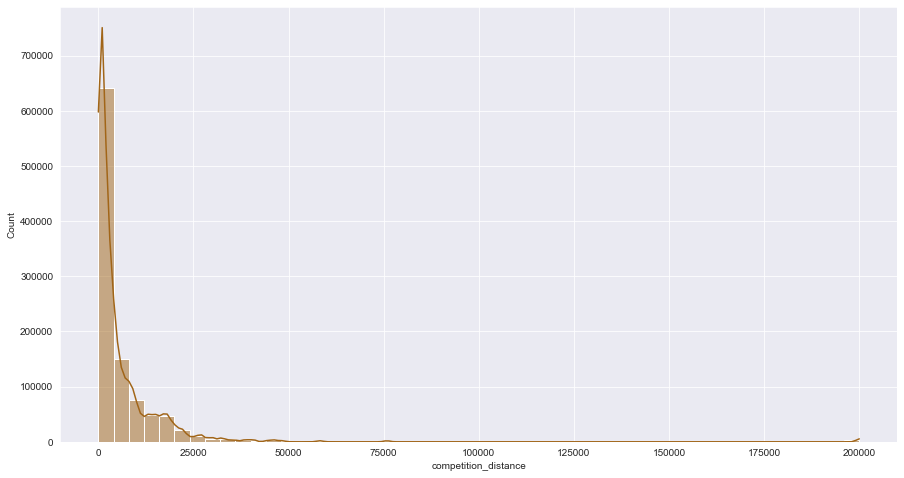

In [33]:
plt.figure( figsize=( 15, 8 ) )
sns.histplot( df1['competition_distance'], kde=True, bins=50 )

### 1.7.2 Categorical Attributes

In [34]:
# unique values of each categorical feature
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Filtering the dataset, taking out the lines that contains the day when the store is closed (sales=0) and filtering by state_holiday (state_holiday=0 means that there isn't any state_holiday).

 - **StateHoliday**: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
 - **StoreType**:    differentiates between 4 different store models: a, b, c, d
 - **Assortment**:   describes an assortment level: a = basic, b = extra, c = extended
 
seing the graphs it's possible take some information such as:

 - The store type "b" has its median much higher than another one's and much outliers as well.
 - The state holiday are much similar among each other.

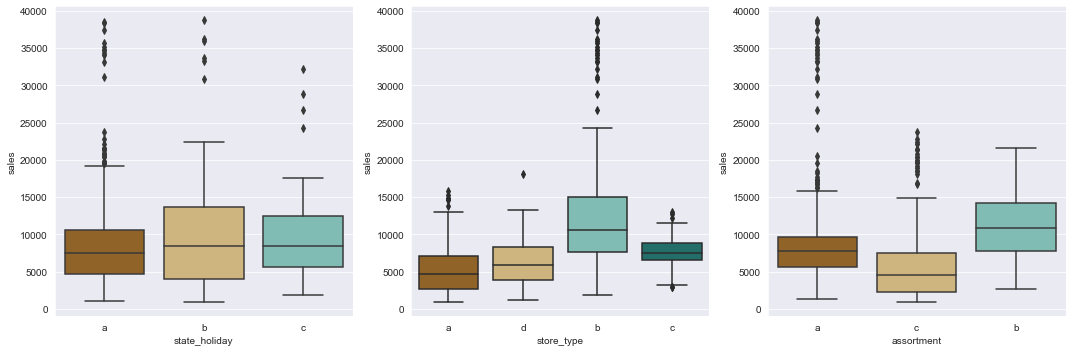

In [35]:
plt.figure( figsize=( 15, 5 ) )

aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] >0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

plt.tight_layout()

# 2.0 Feature Engineering

In [36]:
df2 = df1.copy()

## 2.1. MindMap Hypotesis

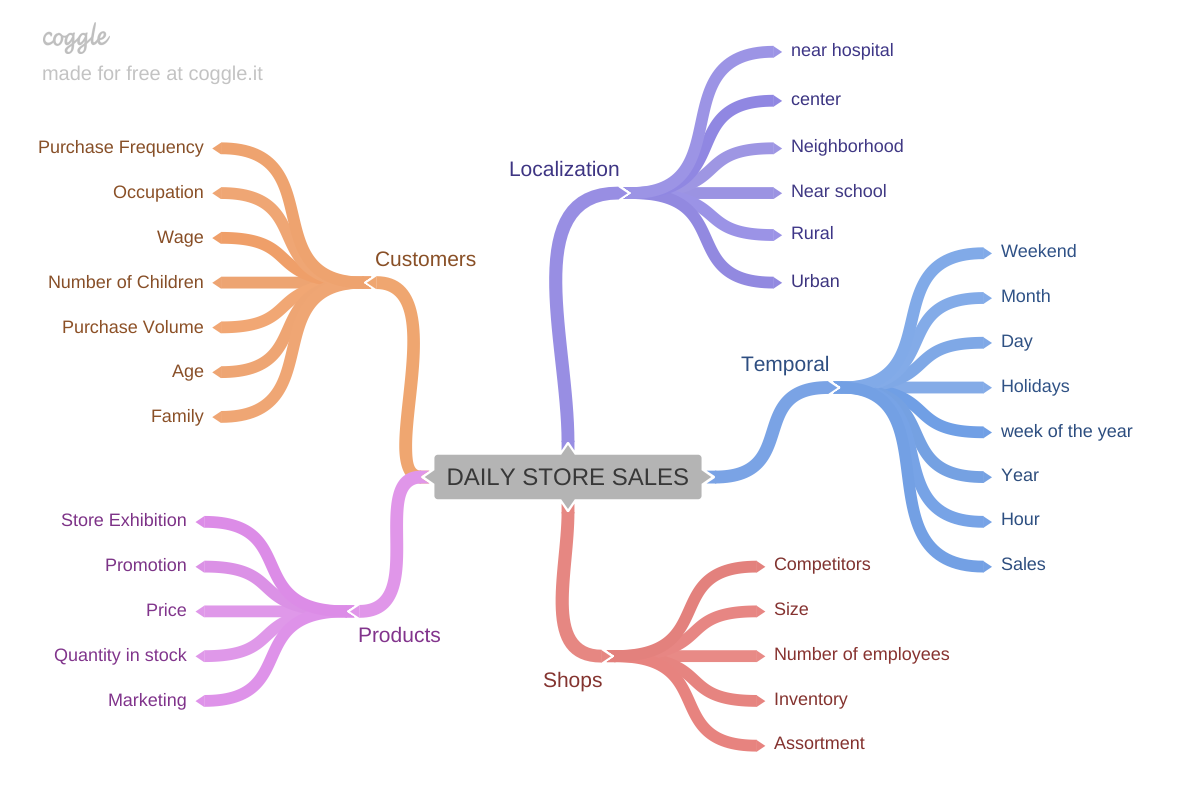

In [37]:
Image( 'img/DAILY_STORE_SALES_01.png' )

## 2.2. Creating Hypotesis

### 2.2.1 Store Hypotesis

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidors mais proximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Store Hypotesis

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas com maior exposição de produto deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais. 

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas compromoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Store Hypotesis

**1.** Lojas abertas durante o feriado de natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante feriados escolares

## 2.3. Final Hypotesis List

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidors mais proximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas compromoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante feriados escolares

## 2.4. Feature Engineering

In [38]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( np.int64 )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-'+ df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days).astype( np.int64 )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'Easter holiday' if x=='b' else 'Christmas' if x=='c' else 'regular_day' )

# 3.0. Filtering Varibles

In [44]:
df3 = df2.copy()

In [45]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtering Rows

In [46]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Filtering Columns

In [47]:
columns_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop( columns_drop, axis=1 )

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')